# Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Load data

In [2]:
from google.colab import auth
import requests

### Find out which user is running the notebook at this instance

In [3]:
auth.authenticate_user()
gcloud_token = !gcloud auth print-access-token
gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
print(gcloud_tokeninfo['email'])

data_path = ''

if gcloud_tokeninfo['email'] == 'theodorgto@gmail.com':
  data_path = 'drive/MyDrive/DTU/Machine Learning SC/Data'
elif gcloud_tokeninfo['email'] == 'gustav@gmail.com':
  data_path = 'drive/MyDrive/' #TODO: gustav find din path i google folder til dataen


print(f"Data Pata: {data_path}")

theodorgto@gmail.com
Data Pata: drive/MyDrive/DTU/Machine Learning SC/Data


### Get data
This section is only for sampling and moving data around. So i think we probably could move this into another notebook in the future.
For now though, just don't run it.

In [ ]:
print(data_path + '/PXL_20231006_105621514.TS.mp4')

drive/MyDrive/DTU/Machine Learning SC/Data/PXL_20231006_105621514.TS.mp4


In [ ]:
from moviepy.editor import VideoFileClip

# Provide the path to your MP4 file
video_path = data_path + '/PXL_20231006_105621514.TS.mp4'

# Load the video file
video = VideoFileClip(video_path)

# Retrieve FPS and duration
fps = video.fps
duration = video.duration
duration_frames = duration * fps

# Print the results
print(f"FPS: {fps}")
print(f"Duration: {duration} seconds")
print(f"Duration in frames: {duration_frames} frames")

n_samples = 100

sample_interval = duration_frames / n_samples

print(f"Number of samples: {n_samples}")
print(f"Sample every: {sample_interval} samples ")

# Close the video file
video.reader.close()

FPS: 30.0
Duration: 32.75 seconds
Duration in frames: 982.5 frames
Number of samples: 100
Sample every: 9.825 samples 


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip
import math

def sampleMp4(file:str):
  # Provide the path to your MP4 file
  video_path = data_path + '/' + file

  # Load the video file
  video = VideoFileClip(video_path)

  # Retrieve FPS and duration
  fps = video.fps
  duration = video.duration
  duration_frames = duration * fps

  # Print the results
  print(f"FPS: {fps}")
  print(f"Duration: {duration} seconds")
  print(f"Duration in frames: {duration_frames} frames")
  n_samples = 100
  sample_interval = duration_frames / n_samples

  print(f"Number of samples: {n_samples}")
  print(f"Sample every: {sample_interval} samples ")

  # Close the video file
  video.reader.close()

  # Open the video file
  video_capture = cv2.VideoCapture(video_path)

  # Check if the video file opened successfully
  if not video_capture.isOpened():
      print("Error: Could not open video file.")

  frame_idx = 0
  samples = []

  # Loop through the frames of the video
  while True: # Toodo: add outer foorloop over ALL videos, and create an iterator with a process bar
      ret, frame = video_capture.read()

      # Check if the video has reached the end
      if not ret:
          break

      if frame_idx % int(sample_interval) == 0:
          samples.append(frame)

      frame_idx += 1

  # Release the video capture object and close the window
  video_capture.release()
  cv2.destroyAllWindows()

  # Crop samples to fit desired length
  if len(samples) > n_samples:
    cut = abs(len(samples) - n_samples)
    lower_bound = math.floor(cut)
    upper_bound = math.ceil(cut) + len(samples)
    samples = samples[lower_bound : upper_bound]

  return samples

In [ ]:
import os
from PIL import Image

SAMPLE_VIDEOS = False # Set this to true if videos should be re-sampled
##TODO: add to samplemp4 such that the images are resized.

if SAMPLE_VIDEOS:
  # find all files (& dirs) in the data folder
  data_files = os.listdir(data_path)

  n_files = len(data_files)

  if not os.path.exists(f"{data_path}/sampled_videos"):
      os.makedirs(f"{data_path}/sampled_videos")

  for file_name in data_files:
    samples = sampleMp4(file_name)
    for frame_number in range(len(samples)):
      image = Image.fromarray(samples[frame_number])  # Convert to PIL Image
      image.save(f'{data_path}/sampled_videos/{file_name}_{frame_number:04d}.jpg')




In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Data loading



## Create dataset class
Later we should look into how this can be handed to a gpu

In [5]:
samples_folder = data_path + '/sampled_videos'

import torchvision
import os
import cv2
from torch.utils.data import Dataset, DataLoader

# Dictionary related postion to x,y coordinates.
# x is along the long axis and y is along the short axis
label = {
    'PXL_20231006_105621514.TS': (1,1),
    'PXL_20231006_105839274.TS': (1,2),
    'PXL_20231006_105912563.TS': (1,3),
    'PXL_20231006_111220943.TS': (1,4),
    'PXL_20231006_111317388.TS': (1,5),

    'PXL_20231006_110008414.TS': (2,1),
    'PXL_20231006_110103438.TS': (2,2),
    'PXL_20231006_110136554.TS': (2,3),
    'PXL_20231006_111150785.TS': (2,4),
    'PXL_20231006_111403886.TS': (2,5),

    'PXL_20231006_110253143.TS': (3,1),
    'PXL_20231006_110454262.TS': (3,2),
    'PXL_20231006_110614512.TS': (3,3),
    'PXL_20231006_111117602.TS': (3,4),
    'PXL_20231006_111451715.TS': (3,5),

    'PXL_20231006_110837241.TS': (4,1),
    'PXL_20231006_110927004.TS': (4,2),
    'PXL_20231006_111012449.TS': (4,4),
    'PXL_20231006_111042814.TS': (4,5),
}

class imageDataset(Dataset):
  def __init__(self, folder_path, transform=None, resize=True):
    # data loading
    self.folder_path = folder_path
    self.transform = transform
    self.resize = resize
    self.image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    self.position = [label[file_name.split(".mp4")[0]] for file_name in self.image_files]

  def __len__(self):
    return len(self.image_files)
    # dataset[0]

  def __getitem__(self, index):
    img_path = os.path.join(self.folder_path, self.image_files[index])
    img = cv2.imread(img_path)
    if self.resize:
      img = cv2.resize(img, (1080 // 10, 1920 // 10))
    img = img / 255.0  # Normalize pixel values

    if self.transform:
        img = torch.tensor(img,dtype=torch.float)
        img = img.permute(2, 1, 0)

        pos = torch.tensor(self.position[index],dtype=torch.float)


    return img,pos




### Seperate dataset into test and validation sets then hand them to the dataloader

Play around with batch size

In [6]:
from torch.utils.data import random_split
# init dataset
dataset = imageDataset(samples_folder,transform=True)

# split dataset randomly into tran and validation.
generator1 = torch.Generator().manual_seed(42) # This is optional but setting it will make outcome reproducible
train_dataset, valid_dataset = random_split(dataset, [0.8, 0.2], generator=generator1)


#dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

### A few sanity checks to make sure the shapes and items are correct

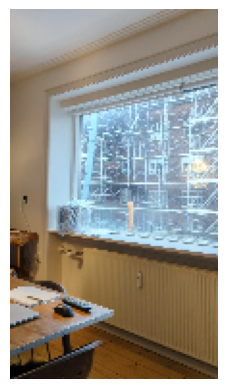

In [7]:
# Show downscaled image for sanity
i,d = dataset[45]
i.permute(2, 1, 0).shape
image_array = i.permute(2, 1, 0)

plt.imshow(image_array)
plt.axis('off')
plt.show()

In [8]:
# Iterate over the DataLoader to inspect the shape of each batch but only for 1 loop
for batch_data, batch_labels in train_loader:
    batch_size, channels, height, width = batch_data.size()
    input_size = width * height * channels
    print(f"Batch size: {batch_size}, Channels: {channels}, Height: {height}, Width: {width}")
    print(f"Labels shape: {len(batch_labels)}")
    break

Batch size: 8, Channels: 3, Height: 108, Width: 192
Labels shape: 8


# Network

In [24]:
import torch.nn.init as init

# Define values
n_outputs = 2 # (x,y) or maybe


# define network
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()

        self.seq = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=8, stride=3),  # First convolutional layer
            nn.ReLU(),  # SoftPlus, ReLu
            nn.MaxPool2d(2),  # Max pooling layer
            nn.Conv2d(3, 1, kernel_size=4, stride=1),  # Second convolutional layer
            nn.ReLU(),  # SoftPlus, ReLu
            nn.MaxPool2d(2),  # Max pooling layer
            # You can add a dropout layer here if needed
            nn.Flatten(),
            nn.Linear(in_features=98, out_features=98),  # Adjust the in_features based on the output size of the previous layer
            nn.ReLU(),
            nn.Linear(in_features=98, out_features=n_outputs),
       )

        # Apply weight initialization
        self.apply(self.initialize_weights)

    def initialize_weights(self, module):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            init.kaiming_uniform_(module.weight, mode='fan_in', nonlinearity='leaky_relu')
            if module.bias is not None:
                init.constant_(module.bias, 0)


    def forward(self, x):
        # Get features before the flattening operation
        features = self.seq[:5](x)  # Slices the sequence up to the flattening layer
        latent_layer = features

        # Continue with the rest of the network
        logits = self.seq[5:](features)
        return logits, latent_layer

model = Model()

print(model)

Model(
  (seq): Sequential(
    (0): Conv2d(3, 3, kernel_size=(8, 8), stride=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 1, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=98, out_features=98, bias=True)
    (8): ReLU()
    (9): Linear(in_features=98, out_features=2, bias=True)
  )
)


In [ ]:
# Find out whether to use GPU or CPU
# gpus = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
# if gpus:
#   print("Available CUDA devices:", gpus)
#   device = torch.device('cuda')  # use cuda or cpu
#   model.to(device)

# else:
#   print("No available CUDA devices. Using cpu")
#   device = torch.device('cpu')  # use cuda or cpu
#   model.to(device)


# Training loop

In [31]:
# initialize model
model = Model()
# Optimizer and Loss
# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # Weight decay, L1, L2 regularization to reduce overfitting

total_samples = len(dataset)
total_batches = total_samples // train_loader.batch_size


num_epochs = 10

# Logging
train_loss = np.zeros(num_epochs)
valid_loss = np.zeros(num_epochs)


for epoch in range(num_epochs):
  # loop over all batches
  model.train()
  train_losses, train_lengths = 0, 0
  for i, (images, pos) in enumerate(train_loader):
    model.train() # To enable dropout
    optimizer.zero_grad()                            # Clear gradients for the next train
    output,_ = model(images)                           # Forward pass: Compute predicted y by passing x to the model
    batch_loss = criterion(output, pos)              # Compute loss
    train_losses += batch_loss
    batch_loss.backward()                            # Backward pass: Compute gradient of the loss with respect to model parameters
    optimizer.step()

    train_lengths += len(images)

  # Divide by the total accumulated batch sizes
  train_losses /= train_lengths
  train_loss[epoch] = train_losses.item()
  print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss : {train_losses.item()}")

  # Do the validaiton
  model.eval()
  val_losses, val_lengths = 0, 0
  for i, (images, pos) in enumerate(valid_loader):
      output,_ = model(images)
      val_losses += criterion(output, pos)
      val_lengths += len(images)

  # Divide by the total accumulated batch sizes
  val_losses /= val_lengths
  valid_loss[epoch] = val_losses.item()
  print(f"Epoch {epoch + 1}/{num_epochs} - Validation Loss : {val_losses.item()}")



Epoch 1/10 - Training Loss : 0.8852443695068359
Epoch 1/10 - Validation Loss : 0.29795798659324646
Epoch 2/10 - Training Loss : 0.29437199234962463
Epoch 2/10 - Validation Loss : 0.2828786373138428
Epoch 3/10 - Training Loss : 0.27529993653297424
Epoch 3/10 - Validation Loss : 0.26241621375083923
Epoch 4/10 - Training Loss : 0.2646898925304413
Epoch 4/10 - Validation Loss : 0.25559094548225403
Epoch 5/10 - Training Loss : 0.2573905885219574
Epoch 5/10 - Validation Loss : 0.2487487494945526
Epoch 6/10 - Training Loss : 0.2511669099330902
Epoch 6/10 - Validation Loss : 0.24350841343402863
Epoch 7/10 - Training Loss : 0.24547091126441956
Epoch 7/10 - Validation Loss : 0.24857579171657562
Epoch 8/10 - Training Loss : 0.24428091943264008
Epoch 8/10 - Validation Loss : 0.24457335472106934
Epoch 9/10 - Training Loss : 0.239888995885849
Epoch 9/10 - Validation Loss : 0.24104216694831848
Epoch 10/10 - Training Loss : 0.23855717480182648
Epoch 10/10 - Validation Loss : 0.23388363420963287


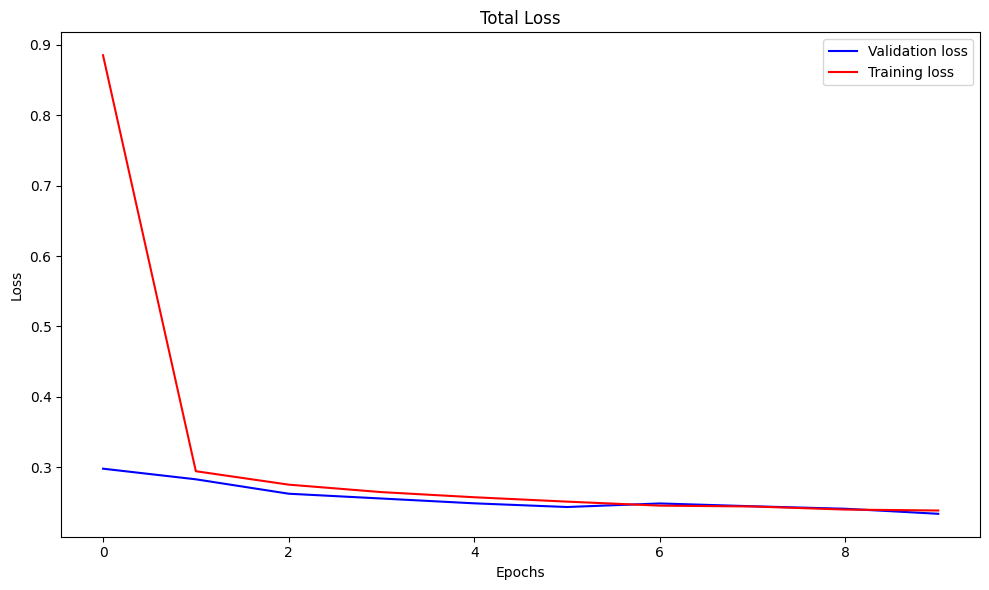

In [32]:
# Plotting the losses
plt.figure(figsize=(10, 6))

plt.plot(range(num_epochs), valid_loss, 'b', label='Validation loss')
plt.plot(range(num_epochs), train_loss, 'r', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Total Loss')

plt.tight_layout()
plt.show()


Plot predicted positions in the room

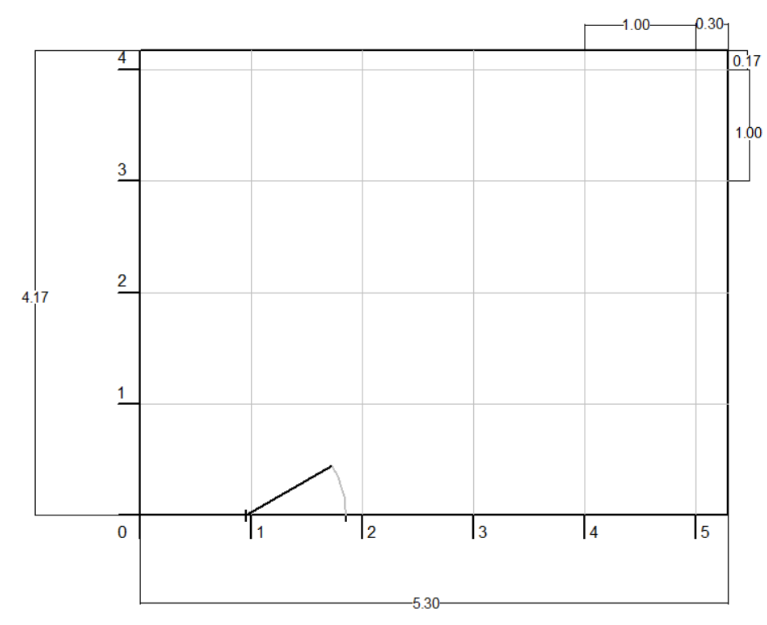

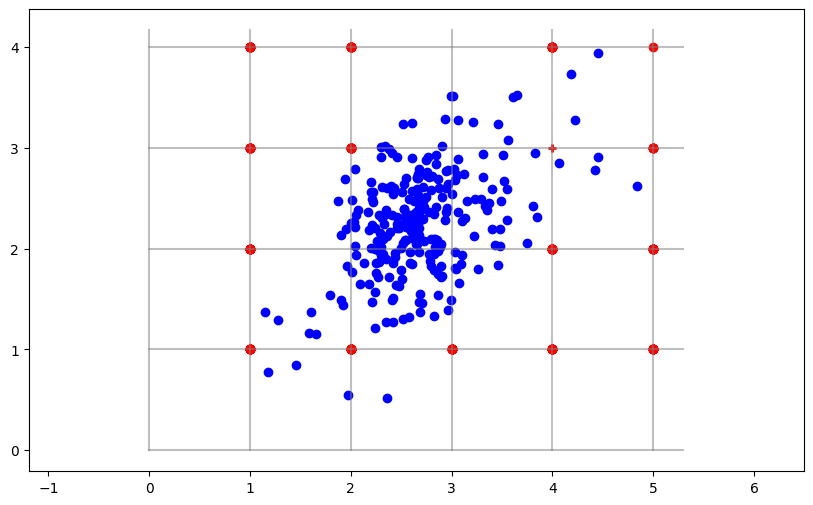

In [33]:
plt.figure(figsize=(10, 6))

width = 5.3
height = 4.17

dx = width / 1000
dy = height / 1000

x = np.arange(0,width,dx)
y = np.arange(0,height,dy)

# plt.plot(x,y)

for i in range(int(height) + 1):
    plt.plot(x, i * np.ones_like(x), color='grey',alpha=0.5)

for i in range(int(width) + 1):
    plt.plot(i * np.ones_like(y),y, color='grey',alpha=0.5)

plt.scatter(4,3, color='red',marker='+',linewidth=2)

# Get model predictions:
model.eval()
pred_positions = []
true_positions = []
for i, (images, pos) in enumerate(valid_loader):
    output,_ = model(images)
    pred_positions.append(output.detach().numpy())
    true_positions.append(pos.detach().numpy())
for position_array in np.array(pred_positions):
  for pos in position_array:
    # print(pos)
    plt.scatter(pos[1],pos[0],color='blue')

for position_array in np.array(true_positions):
  for pos in position_array:
    # print(pos)
    plt.scatter(pos[1],pos[0],color='red')

plt.xlim(0,width)
plt.ylim(0,height)
# Set axis scale to be constant
plt.axis('equal')
plt.show()

Latent_layer shape : torch.Size([1, 14, 28])
Labbled pos tensor([2., 4.]). Prediction tensor([[2.3664, 2.8457]], grad_fn=<AddmmBackward0>)


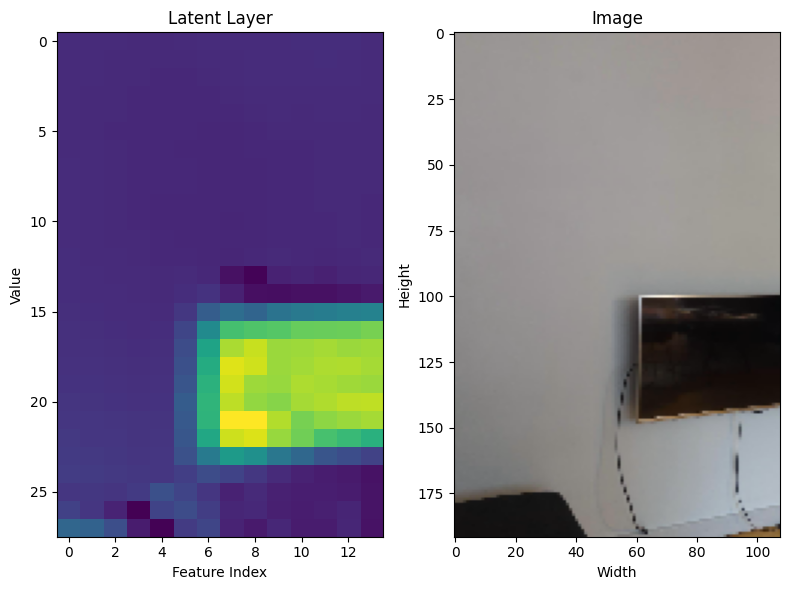

In [15]:
# Show downscaled image for sanity
img,pos = dataset[45*2]
pred_pos,latent_layer = model(img)

print(f"Latent_layer shape : {latent_layer.shape}")

print(f"Labbled pos {pos}. Prediction {pred_pos}")

fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Plot the latent feature map
latent_layer_map = torch.rot90(latent_layer[0].flip(1))
axs[0].imshow(latent_layer_map.detach().numpy(), cmap='viridis', aspect='auto')
axs[0].set_title('Latent Layer')
axs[0].set_xlabel('Feature Index')
axs[0].set_ylabel('Value')
axs[0].set_aspect('auto')  # Adjust aspect ratio to match the number of features

# Plot the image
image_array = img.permute(2, 1, 0)
axs[1].imshow(image_array, aspect='auto')
axs[1].set_title('Image')
axs[1].set_xlabel('Width')
axs[1].set_ylabel('Height')

plt.tight_layout()
plt.show()

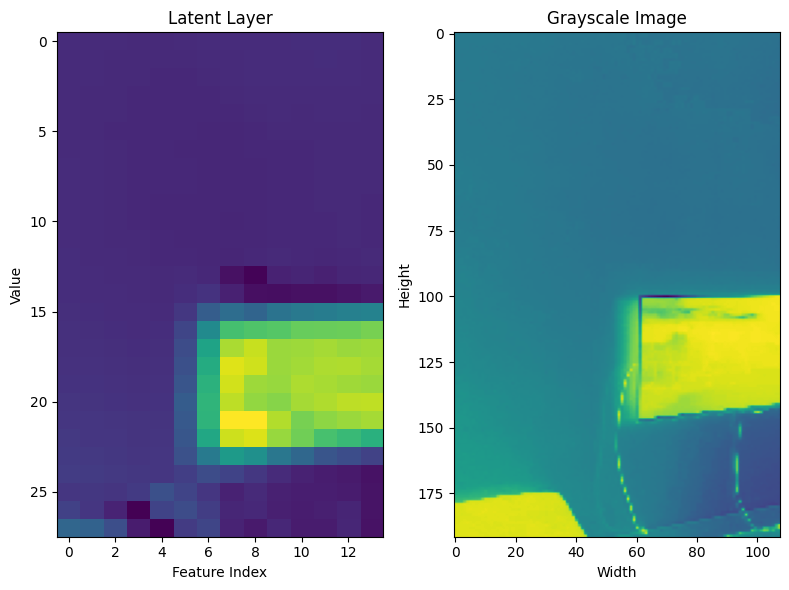

In [16]:
from matplotlib.colors import rgb_to_hsv

# Assuming img is an RGB image with shape (3, 108, 192)
image_array = img.permute(2, 1, 0).numpy()

# Convert the RGB image to grayscale using the Viridis colormap
hsv_image = rgb_to_hsv(image_array)
gray_image = hsv_image[:, :, 2]

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Plot the latent feature map
latent_layer_map = torch.rot90(latent_layer[0].flip(1))
axs[0].imshow(latent_layer_map.detach().numpy(), cmap='viridis', aspect='auto')
axs[0].set_title('Latent Layer')
axs[0].set_xlabel('Feature Index')
axs[0].set_ylabel('Value')

# Plot the grayscale image using the Viridis colormap
axs[1].imshow(-gray_image, cmap='viridis', aspect='auto')
axs[1].set_title('Grayscale Image')
axs[1].set_xlabel('Width')
axs[1].set_ylabel('Height')

plt.tight_layout()
plt.show()